# Business Problem

A **Cardio Catch Diseases** (fictício) é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O seu modelo de negócio é do tipo Serviço, ou seja, a empresa ofereço o diagnóstico precoce de uma doença cardiovascular por um certo preço.

O **preço do diagnóstico**, pago pelo cliente, varia de acordo com a precisão conseguida pelo time de especialistas, o cliente paga US$\$$ 500.00 a cada 5% de acurácia acima de 50%. Por exemplo, para uma precisão de 55%, o diagnóstico custa US$\$$ 500.00 para o cliente, para uma precisão de 60%, o valor é de US$\$$ 1000.00 e assim por diante. Se a precisão do diagnóstico for 50% o cliente não paga por ele.

| Accuracy        |Cost Diagnostics |
| :------:        | :------------:  |
| 50%            | US$\$$ 0         |
| 55%            | US$\$$ 500       |
| 60%            | US$\$$ 1000      |

Observe que a variação da precisão dada pelo time de especialistas, faz com que a empresa tenha ora uma operação com lucro, receita maior que o custo, ora uma operação com prejuízo, receita menor que o custo. Essa instabilidade do diagnóstico faz com que a empresa tenha um **Cashflow** imprevisível.

### Main Objective:
* Criar uma máquina preditiva com a precisão estável e evitar o cashflow.

### Strategy:

1. Research on the scope of the problem
2. Data Collect
3. Data Cleaning (missing values, inconsistent values)
4. Create business hypotheses: 

   **H1:** O grupo de pacientes do gênero masculino são 30% das que apresentam a doença. 
   
   **H2:** O grupo de pacientes que fumam são 40% das que apresentam a doença.
   
   **H3:** O grupo de pacientes com a altura de mais de 145cm são 45% das que apresentam a doença.
   
   **H4:** O grupo de pacientes que consomem álcool são 75% das que apresentam a doença.
   
   **H5:** O grupo de pacientes com a glicose bem acima do normal são 50% das que apresentam a doença.
   
   **H6:** O grupo de pacientes que não praticam atividade física são 15% das que apresentam a doença.
   
   **H7:** O grupo de pacientes com o colesterol acima do normal são 45% das que apresentam a doença.
   
   **H8:** O grupo de pacientes com o peso maior do que 90kg são 60% das que apresentam a doença.
   
   **H9:** O grupo de pacientes com a idade acima de 50 anos são 60% das que apresentam a doença.
   
   
5. Exploratory Data Analysis (attribute analysis, validate the hypotheses)
6. Data Preprocessing (data split, data scaling)
7. Training the model (XGBoost, kNN, Random Forest)
8. Hyperparameter fine-tuning
9. Translation of model performance to business performance
10. Deploy to Production: [Cardiovascular Disease App](https://cardio-disease-predict-sc30.herokuapp.com)

# Business Results

O serviço atual da Cardio Catch Diseases gerava prejuizo, não tendo uma precisão dos diagnósticos estáveis. Comparando com a precisão estável do projeto finalizado, a empresa sairia ganhando implementando esse modelo de serviço.

A comparação foi feita levando em conta o **melhor e o pior cenário** de cada situação.

| Type          | Best Scenario   | Worst Scenario |
| :-------------------:    | :-------------: | :------------: |
| Specialist Team                    | US$\$$ 70.000.000  | US$\$$ 35.000.000 |
| Machine Learning Algorithm         | US$\$$ 140.000.000 | US$\$$ 105.000.000|

Cada diagnóstico pago pelo cliente, agora terá o preço de **US$ 2000.00** sem alguma variação nesse preço.


# 1.0 Imports

In [1]:
import kaggle
from zipfile import ZipFile

import pandas as pd
import numpy as np

import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')

# 2.0 Functions

In [2]:
def metrics(model, x, y):
    pred = model.predict(x)
    acc = accuracy_score(y, pred)
    acc = round(acc * 100, 2)
    
    print('Accuracy Score: {}%\n'.format(acc))
    
    print(classification_report(y, pred))
    
    skplt.metrics.plot_confusion_matrix(y, pred, figsize=(10,10), title='Confusion Matrix')
    plt.show()
    
    return None
    
def barplot(data, x):
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.countplot(data= data, x= x, palette='Blues')
    ax.set_facecolor('#EAEAF2')
    ax.set_xlabel(x, fontdict={'fontsize':14})
    ax.set_ylabel('Count Disease', fontdict={'fontsize':14})
    ax.tick_params(labelsize=14)
    fig.tight_layout()
    
    # percentage
    total = len(data[[x]])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    
    return None

# 3.0 Data Collect

In [5]:
!kaggle datasets download -d sulianova/cardiovascular-disease-dataset

file_name = 'cardiovascular-disease-dataset.zip' 

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')


Done



  0%|          | 0.00/742k [00:00<?, ?B/s]
100%|##########| 742k/742k [00:00<00:00, 8.08MB/s]


In [3]:
data = pd.read_csv('cardio_train.csv', sep=';')
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [7]:
data.shape

(70000, 13)

## 3.1 Descriptive Analysis

In [8]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# 4.0 Data Cleaning

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [10]:
data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [11]:
data.duplicated().sum()

0

# 5.0 Exploratory Data Analysis

## 5.1 Univariate Analysis

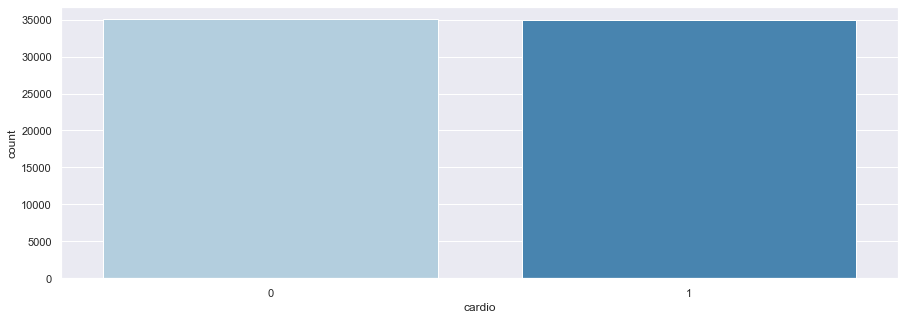

In [12]:
sns.set(rc={'figure.figsize': (15,5)})
sns.countplot(x= data['cardio'], palette='Blues');

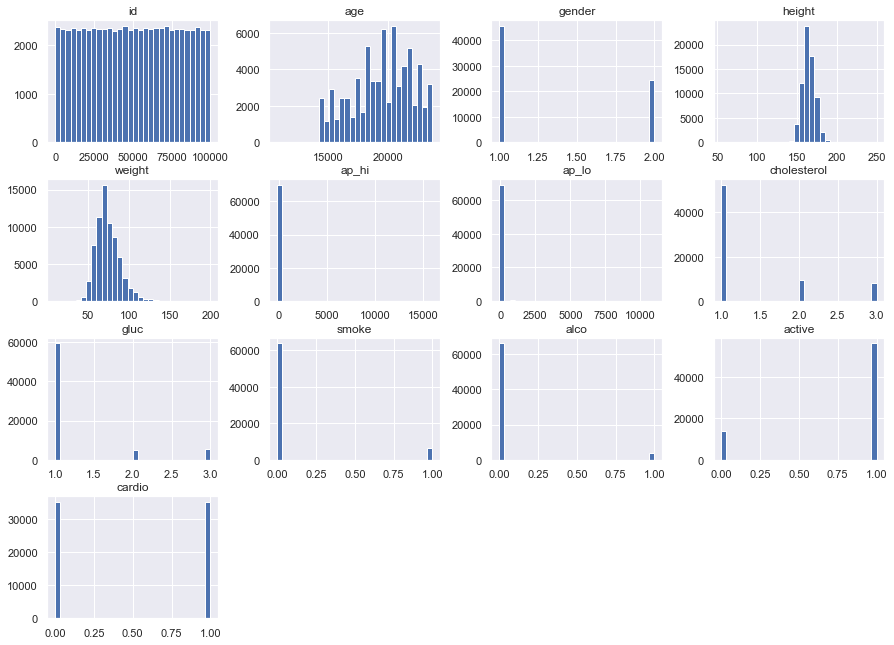

In [13]:
sns.set(rc={'figure.figsize': (15,11)})

data.hist(bins=30);

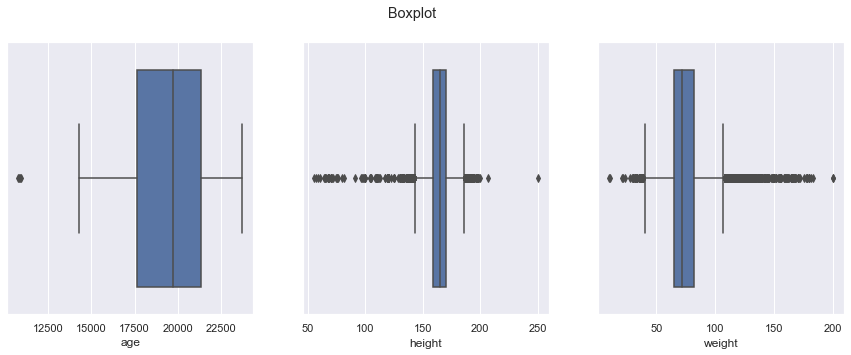

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Boxplot')

sns.boxplot(ax=ax[0], x=data['age'])

sns.boxplot(ax=ax[1], x=data['height'])

sns.boxplot(ax=ax[2], x=data['weight']);

## 5.2 Bivariate Analysis

### H1: O grupo de pacientes do gênero masculino são 30% das que apresentam a doença. 
**TRUE:** O grupo de pacientes do gênero masculino são **35.3%** das que apresentam a doença.

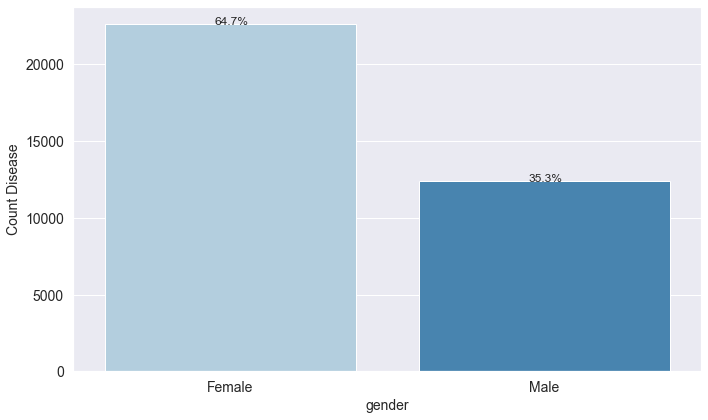

In [15]:
df = data[['gender','cardio']].copy()
df['gender']= df['gender'].map({1:'Female', 2:'Male'})
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'gender')

### H2: O grupo de pacientes que fumam são 40% das que apresentam a doença.
**FALSE:** O grupo de pacientes que fuman são **8.4%** das que apresentam a doença.

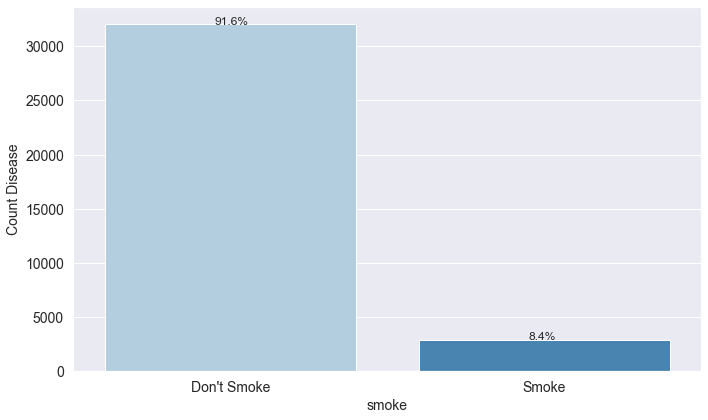

In [16]:
df = data[['smoke','cardio']].copy()
df['smoke']= df['smoke'].map({0:"Don't Smoke", 1:"Smoke"})
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'smoke')

### H3: O grupo de pacientes com a altura de mais de 145cm são 45% das que apresentam a doença.
**TRUE:** O grupo de paciente com a altura de mais de 145cm são **99.4%** das que apresentam a doença.

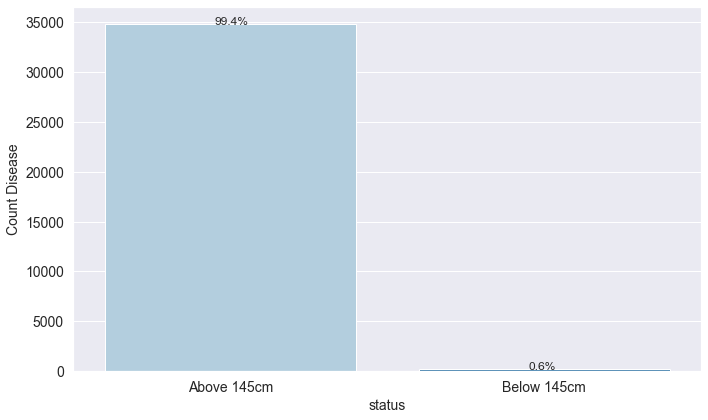

In [17]:
df = data[['height','cardio']].copy()

df['status'] = 'NA'

for i in range(len(df)):
    if (df.loc[i, 'height'] < 145):
        df.loc[i, 'status'] = 'Below 145cm'
    else:
        df.loc[i, 'status'] = 'Above 145cm'
        
df.drop(['height'], axis=1, inplace=True)
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'status')

### H4: O grupo de pacientes que consomem álcool são 75% das que apresentam a doença.
**FALSE:** O grupo de pacientes que consomem álcool são **5.2%** das que apresentam a doença.

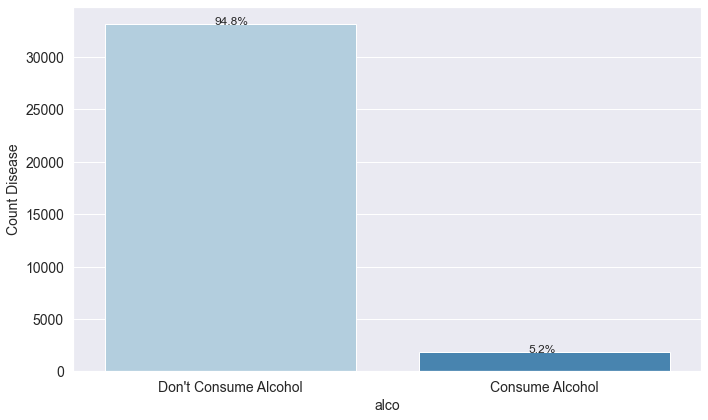

In [18]:
df = data[['alco','cardio']].copy()
df['alco']= df['alco'].map({0:"Don't Consume Alcohol", 1:"Consume Alcohol"})
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'alco')

### H5: O grupo de pacientes com a glicose bem acima do normal são 50% das que apresentam a doença.
**FALSE:** O grupo de pacientes com a glicose bem acima do normal são **9.5%** das que apresentam a doença.

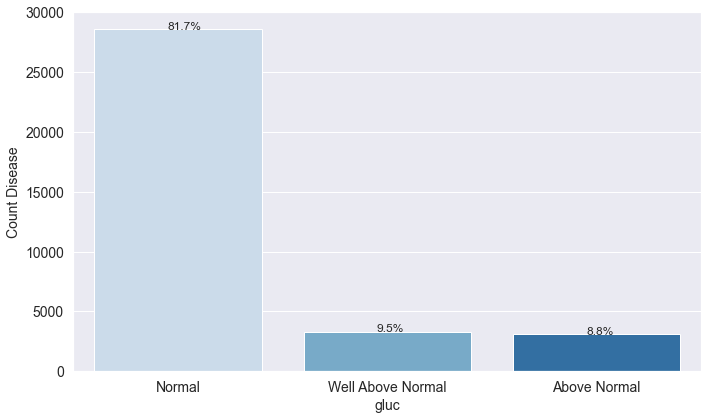

In [19]:
df = data[['gluc','cardio']].copy()
df['gluc']= df['gluc'].map({1:'Normal', 2:'Above Normal', 3:'Well Above Normal'})
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'gluc')

### H6: O grupo de pacientes que não praticam atividade física são 15% das que apresentam a doença.
**TRUE:** O grupo de pacientes que não praticam atividade física são **21%** das que apresentam a doença.

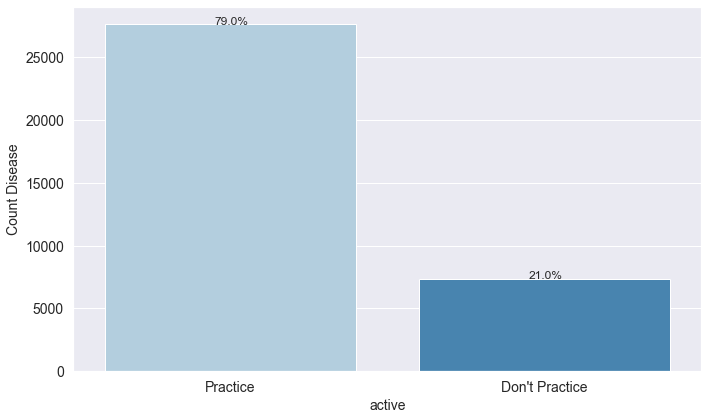

In [20]:
df = data[['active','cardio']].copy()
df['active']= df['active'].map({0:"Don't Practice", 1:"Practice"})
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'active')

### H7: O grupo de pacientes com o colesterol acima do normal são 45% das que apresentam a doença.
**FALSE:** O grupo de pacientes com o colesterol acima do normal são **16.4%** das que apresentam a doença.

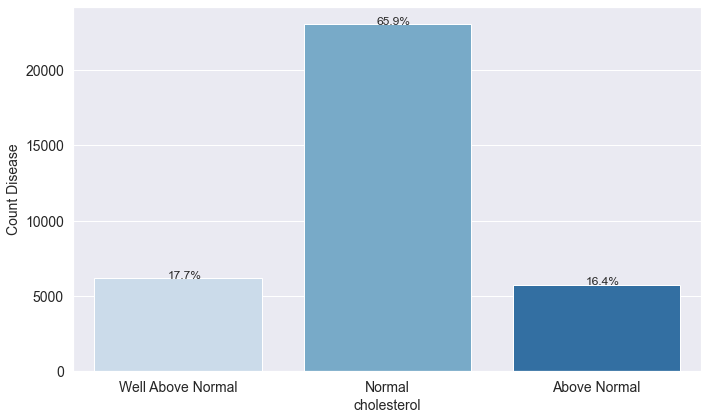

In [21]:
df = data[['cholesterol','cardio']].copy()
df['cholesterol']= df['cholesterol'].map({1:'Normal', 2:'Above Normal', 3:'Well Above Normal'})
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'cholesterol')

### H8: O grupo de pacientes com o peso maior do que 90kg são 60% das que apresentam a doença.
**FALSE:** O grupo de pacientes com o peso maior do que 90kg são **18.2%** das que apresentam a doença.

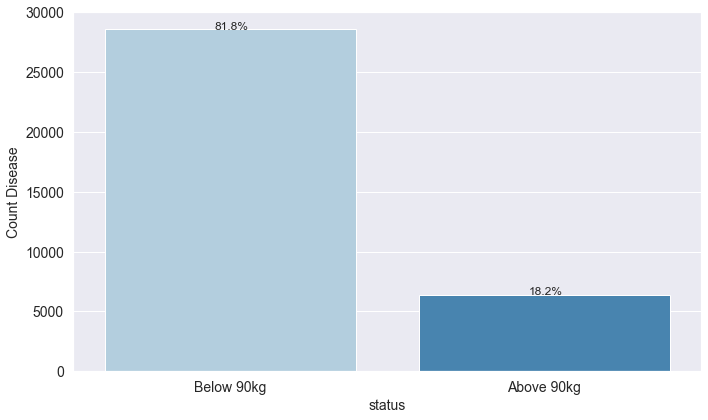

In [22]:
df = data[['weight','cardio']].copy()

df['status'] = 'NA'

for i in range(len(df)):
    if (df.loc[i, 'weight'] < 90):
        df.loc[i, 'status'] = 'Below 90kg'
    else:
        df.loc[i, 'status'] = 'Above 90kg'
        
df.drop(['weight'], axis=1, inplace=True)
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'status')

### H9: O grupo de pacientes com a idade acima de 50 anos são 60% das que apresentam a doença.
**TRUE:** O grupo de pacientes com a idade acima de 50 anos são **77.5%** das que apresentam a doença.

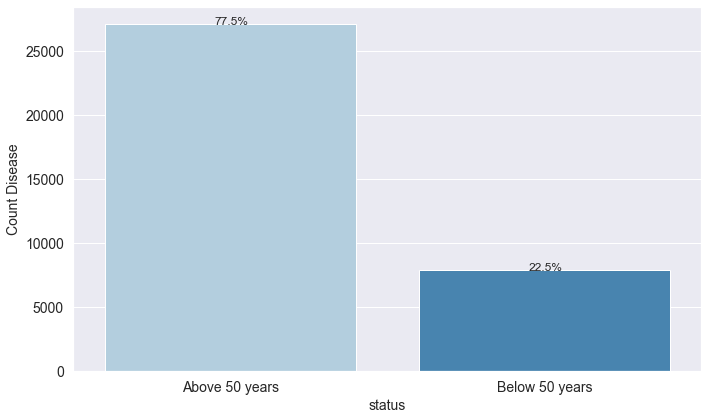

In [23]:
df = data[['age','cardio']].copy()

df['age'] = df['age'] / 365
df['age'] = df['age'].astype(np.int64)

df['status'] = 'NA'

for i in range(len(df)):
    if (df.loc[i, 'age'] < 50):
        df.loc[i, 'status'] = 'Below 50 years'
    else:
        df.loc[i, 'status'] = 'Above 50 years'
        
df.drop(['age'], axis=1, inplace=True)
df = df.drop(df[df.cardio == 0].index)

barplot(data= df, x= 'status')

## 5.3 Multivariate Analysis

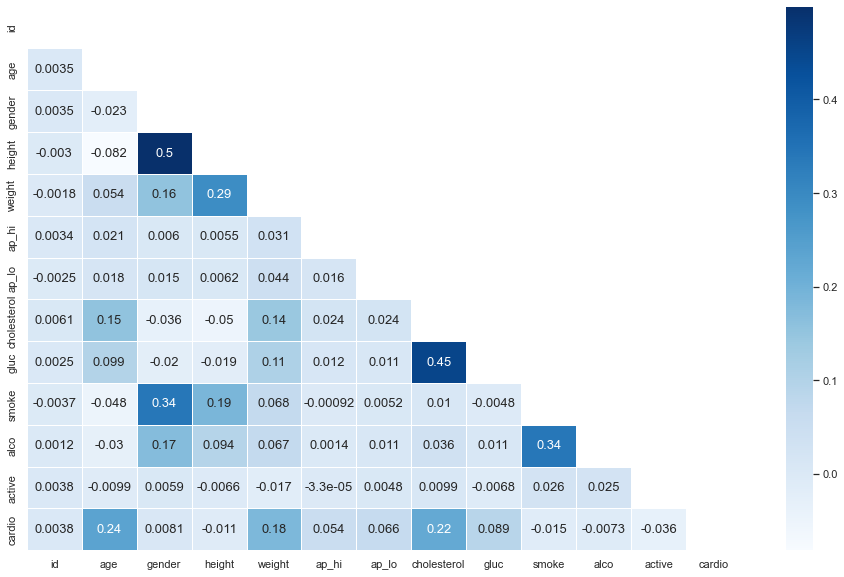

In [24]:
mask = np.zeros_like(data.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

sns.set_style('white')
plt.figure(figsize=(16,10))

sns.heatmap(data.corr(), cmap="Blues", annot=True, mask=mask, annot_kws={'size': 13}, linewidths=0.5)


plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

# 6.0 Data Pre-Processing

Arrumando os valores inconsistentes das colunas **ap_hi** e **ap_lo** 

In [4]:
for i in range(len(data)):
    if (data.loc[i,'ap_hi'] >= 310) & (data.loc[i,'ap_hi'] <= 3000):
        data.loc[i,'ap_hi'] = data.loc[i,'ap_hi'] / 10
    
    elif (data.loc[i,'ap_lo'] >= 200) & (data.loc[i,'ap_lo'] <= 2500):
        data.loc[i,'ap_lo'] = data.loc[i,'ap_lo'] / 10
        
    elif (data.loc[i,'ap_hi'] >= 10000) & (data.loc[i,'ap_hi'] <= 17000):
        data.loc[i,'ap_hi'] = data.loc[i,'ap_hi'] / 100
    
    elif (data.loc[i,'ap_lo'] >= 3000) & (data.loc[i,'ap_lo'] <= 17000):
        data.loc[i,'ap_lo'] = data.loc[i,'ap_lo'] / 100

## 6.1 Data Scaling

Escalonando com o **RobustScaler** para tratar os outliers presentes no dataset

In [5]:
X_cardio = data.drop(['id','cardio'], axis=1).values
y_cardio = data['cardio'].values

scaler = RobustScaler()
X_cardio = scaler.fit_transform(X_cardio)

## 6.2 Data Splitting

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_cardio, y_cardio, test_size=0.30, random_state= 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((49000, 11), (49000,), (21000, 11), (21000,))

# 7.0 Machine Learning Modelling

## kNN

Accuracy Score: 69.94%

              precision    recall  f1-score   support

           0       0.70      0.70      0.70     10461
           1       0.70      0.69      0.70     10539

    accuracy                           0.70     21000
   macro avg       0.70      0.70      0.70     21000
weighted avg       0.70      0.70      0.70     21000



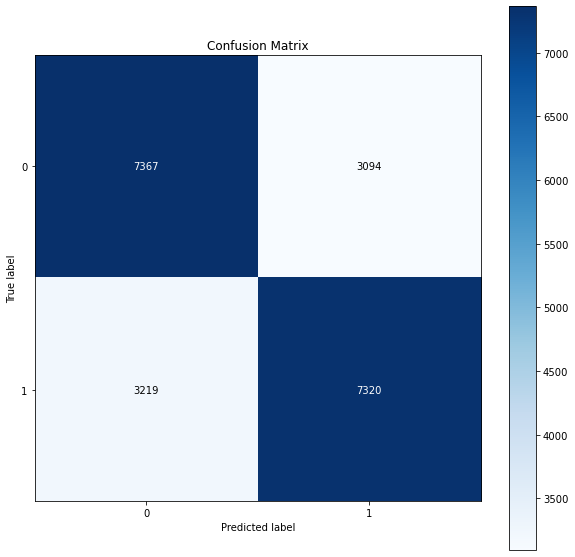

In [12]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

metrics(model, X_test, y_test)

## XGBoost

Accuracy Score: 73.38%

              precision    recall  f1-score   support

           0       0.71      0.77      0.74     10461
           1       0.76      0.69      0.72     10539

    accuracy                           0.73     21000
   macro avg       0.74      0.73      0.73     21000
weighted avg       0.74      0.73      0.73     21000



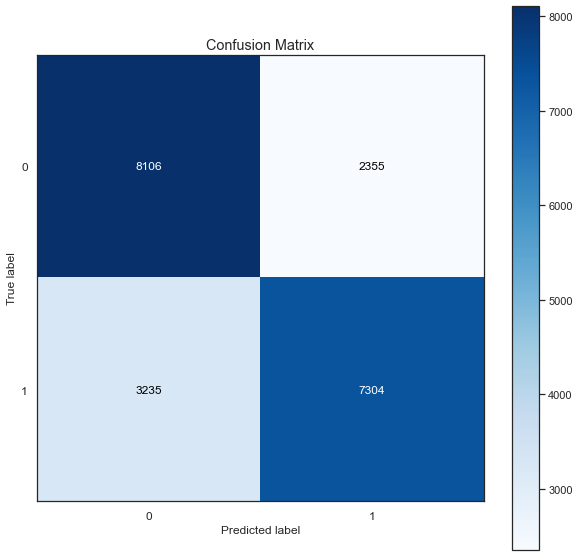

In [29]:
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

metrics(model, X_test, y_test)

## Random Forest

Accuracy Score: 71.83%

              precision    recall  f1-score   support

           0       0.71      0.73      0.72     10461
           1       0.73      0.70      0.71     10539

    accuracy                           0.72     21000
   macro avg       0.72      0.72      0.72     21000
weighted avg       0.72      0.72      0.72     21000



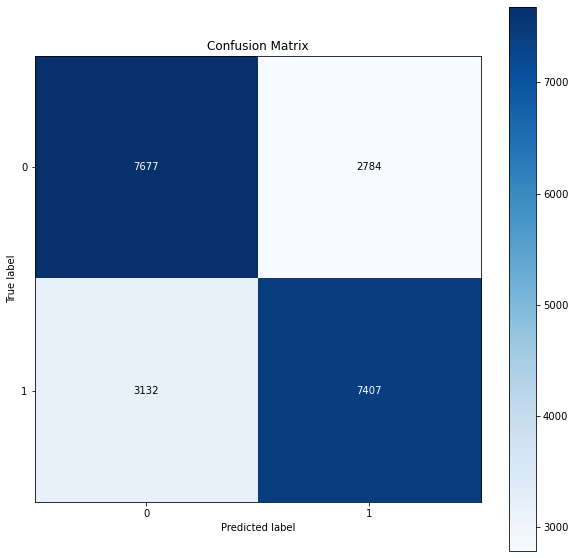

In [7]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

metrics(model, X_test, y_test)

# 8.0 Hyperparameter tuning

Accuracy Score: 74.04%

              precision    recall  f1-score   support

           0       0.72      0.78      0.75     10461
           1       0.76      0.70      0.73     10539

    accuracy                           0.74     21000
   macro avg       0.74      0.74      0.74     21000
weighted avg       0.74      0.74      0.74     21000



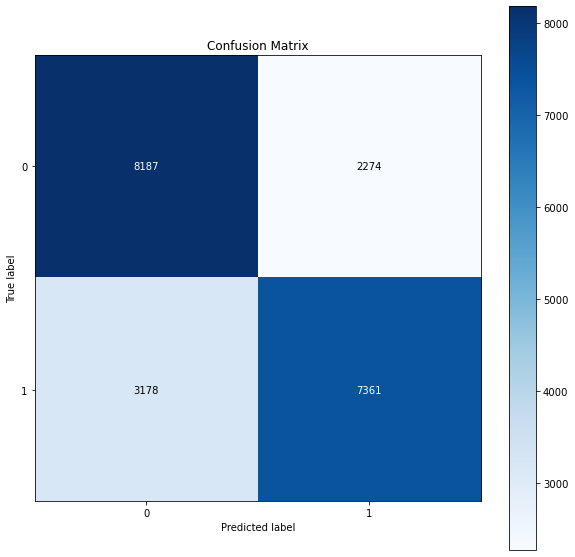

In [10]:
model = XGBClassifier(max_depth= 4, subsample= 1, colsample_bytree= 1, 
                      gamma= 0, learning_rate= 0.01, reg_alpha= 0.001,
                      n_estimators= 1000, eval_metric='logloss', seed= 27)
model.fit(X_train, y_train)

metrics(model, X_test, y_test)

salvando o modelo treinado para subir no deploy

In [13]:
pickle.dump(model, open('model.pkl', 'wb'))